## Time Series Analysis, Visualization & Forecasting with LSTM

In [2]:
import numpy as np
import matplotlib.pyplot as plt #for plotting
import pandas as pd #data manipulation

pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sn #for plotting
import warnings

warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller #checking stationarity of time series
from statsmodels.tsa.stattools import pacf #to obtain the Partial auto correlation

%matplotlib inline

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler #scaling the data
from sklearn.metrics import mean_squared_error #for model evaluation
from sklearn.metrics import mean_absolute_error #for model evaluation
from keras.callbacks import EarlyStopping, ModelCheckpoint


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## The Data

In [3]:
# Loading the data
data = pd.read_csv('csv/bangalore.csv', index_col='date_time',
                   parse_dates=['date_time', 'sunrise', 'sunset'])
print('Number of rows and columns:', data.shape)
data.head(2)

Number of rows and columns: (30144, 24)


,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,24,17,0.0000,7.3000,5,1,100,06:48 PM,07:01 AM,2020-05-18 06:42:00,2020-05-18 18:04:00,18,18,18,18,15,100,98,0.0000,1013,18,0,115,9
2010-01-01 03:00:00,24,17,0.0000,7.3000,5,1,100,06:48 PM,07:01 AM,2020-05-18 06:42:00,2020-05-18 18:04:00,17,17,17,17,9,100,99,0.0000,1013,17,0,90,5


In [4]:
# checking the total count, null values, data type
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30144 entries, 2010-01-01 00:00:00 to 2020-04-25 21:00:00
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   maxtempC           30144 non-null  int64         
 1   mintempC           30144 non-null  int64         
 2   totalSnow_cm       30144 non-null  float64       
 3   sunHour            30144 non-null  float64       
 4   uvIndex            30144 non-null  int64         
 5   uvIndex.1          30144 non-null  int64         
 6   moon_illumination  30144 non-null  int64         
 7   moonrise           30144 non-null  object        
 8   moonset            30144 non-null  object        
 9   sunrise            30144 non-null  datetime64[ns]
 10  sunset             30144 non-null  datetime64[ns]
 11  DewPointC          30144 non-null  int64         
 12  FeelsLikeC         30144 non-null  int64         
 13  HeatIndexC         30144 n

<h3>It's a clean, easy to understand set of data</h3>

In [0]:
# feature engineering

no_moonrise = pd.Series((data.moonrise=='No moonrise').astype(int),name='no_moonrise')
no_moonset = pd.Series((data.moonset == 'No moonset').astype(int),name='no_moonset')
data.replace({'moonrise':'No moonrise', 'moonset':'No moonset'}, 0, inplace=True)

In [6]:
data.moonset[data.moonset == 'No moonset'].size, data.moonrise[data.moonrise=='No moonrise'].size

(0, 0)

In [0]:
# feature engineering and featurization

sunrise_m = pd.Series(data.sunrise.apply(lambda x: x.hour*60 + x.minute),name='sunrise_m')
sunset_m = pd.Series(data.sunset.apply(lambda x: x.hour*60 + x.minute),name='sunset_m')
moonrise_m = pd.Series(pd.to_datetime(data.moonrise).apply(lambda x: x.hour*60 + x.minute),name='moonrise_m')
moonset_m = pd.Series(pd.to_datetime(data.moonset).apply(lambda x: x.hour*60 + x.minute),name='moonset_m')
month = pd.Series(data.index, index=data.index, name='month').apply(lambda x: x.month)
days = pd.Series(data.index, index=data.index, name = 'days').apply(lambda x: x.dayofyear)
weekday = pd.Series(data.index, index=data.index, name = 'weekday').apply(lambda x: x.weekday() < 5).astype(int)

In [8]:
data.drop(['sunrise', 'sunset', 'moonrise','moonset', 'totalSnow_cm'], axis = 1, inplace=True)
data.shape

(30144, 19)

In [0]:
df = pd.concat([sunrise_m, sunset_m, moonrise_m, no_moonrise, moonset_m, no_moonset, month, days, weekday], axis = 1)

In [10]:
df.head()

,sunrise_m,sunset_m,moonrise_m,no_moonrise,moonset_m,no_moonset,month,days,weekday
date_time,,,,,,,,,
2010-01-01 00:00:00,402,1084,1128,0,421,0,1,1,1
2010-01-01 03:00:00,402,1084,1128,0,421,0,1,1,1
2010-01-01 06:00:00,402,1084,1128,0,421,0,1,1,1
2010-01-01 09:00:00,402,1084,1128,0,421,0,1,1,1
2010-01-01 12:00:00,402,1084,1128,0,421,0,1,1,1


In [11]:
dataset = pd.concat([data, df], axis = 1)

dataset.shape

(30144, 28)

In [12]:
#Generating descriptive statistics
dataset.describe()

,maxtempC,mintempC,sunHour,uvIndex,uvIndex.1,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,sunrise_m,sunset_m,moonrise_m,no_moonrise,moonset_m,no_moonset,month,days,weekday
count,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000,30144.0000
mean,29.7606,19.4042,10.6943,5.9496,3.8317,46.0600,15.9112,25.0698,25.3342,24.5239,17.6088,33.6811,63.9880,0.2288,1010.6201,24.0900,9.3516,174.1129,12.6679,376.1311,1103.5247,692.5953,0.0340,695.5573,0.0337,6.3976,179.2643,0.7142
std,3.3600,2.8057,1.9337,0.8547,2.9262,31.2796,4.2706,4.7010,4.5674,4.6750,7.6448,28.9345,22.4017,1.1049,3.2430,4.7159,2.2771,90.5930,5.8563,17.0089,18.8628,429.5547,0.1812,428.7413,0.1805,3.4733,106.1613,0.4518
min,19.0000,11.0000,4.2000,4.0000,1.0000,0.0000,-9.0000,12.0000,13.0000,12.0000,0.0000,0.0000,6.0000,0.0000,1000.0000,0.0000,0.0000,0.0000,0.0000,352.0000,1070.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
25%,27.0000,18.0000,8.9000,5.0000,1.0000,18.0000,14.0000,21.0000,21.0000,21.0000,12.0000,8.0000,48.0000,0.0000,1008.0000,21.0000,10.0000,94.0000,9.0000,363.7500,1087.0000,316.0000,0.0000,322.7500,0.0000,3.0000,86.0000,0.0000
50%,29.0000,20.0000,11.6000,6.0000,1.0000,46.0000,17.0000,25.0000,25.0000,24.0000,17.0000,27.0000,67.0000,0.0000,1010.0000,24.0000,10.0000,154.0000,12.0000,370.0000,1109.0000,692.0000,0.0000,695.0000,0.0000,6.0000,177.0000,1.0000
75%,32.0000,21.0000,11.6000,7.0000,7.0000,73.0000,19.0000,28.0000,28.0000,28.0000,23.0000,51.0000,83.0000,0.0000,1013.0000,27.0000,10.0000,261.0000,16.0000,391.0000,1118.0000,1064.0000,0.0000,1068.0000,0.0000,9.0000,271.2500,1.0000
max,40.0000,28.0000,12.9000,8.0000,10.0000,100.0000,25.0000,43.0000,43.0000,42.0000,53.0000,100.0000,100.0000,38.1000,1021.0000,40.0000,20.0000,360.0000,41.0000,406.0000,1130.0000,1439.0000,1.0000,1439.0000,1.0000,12.0000,366.0000,1.0000


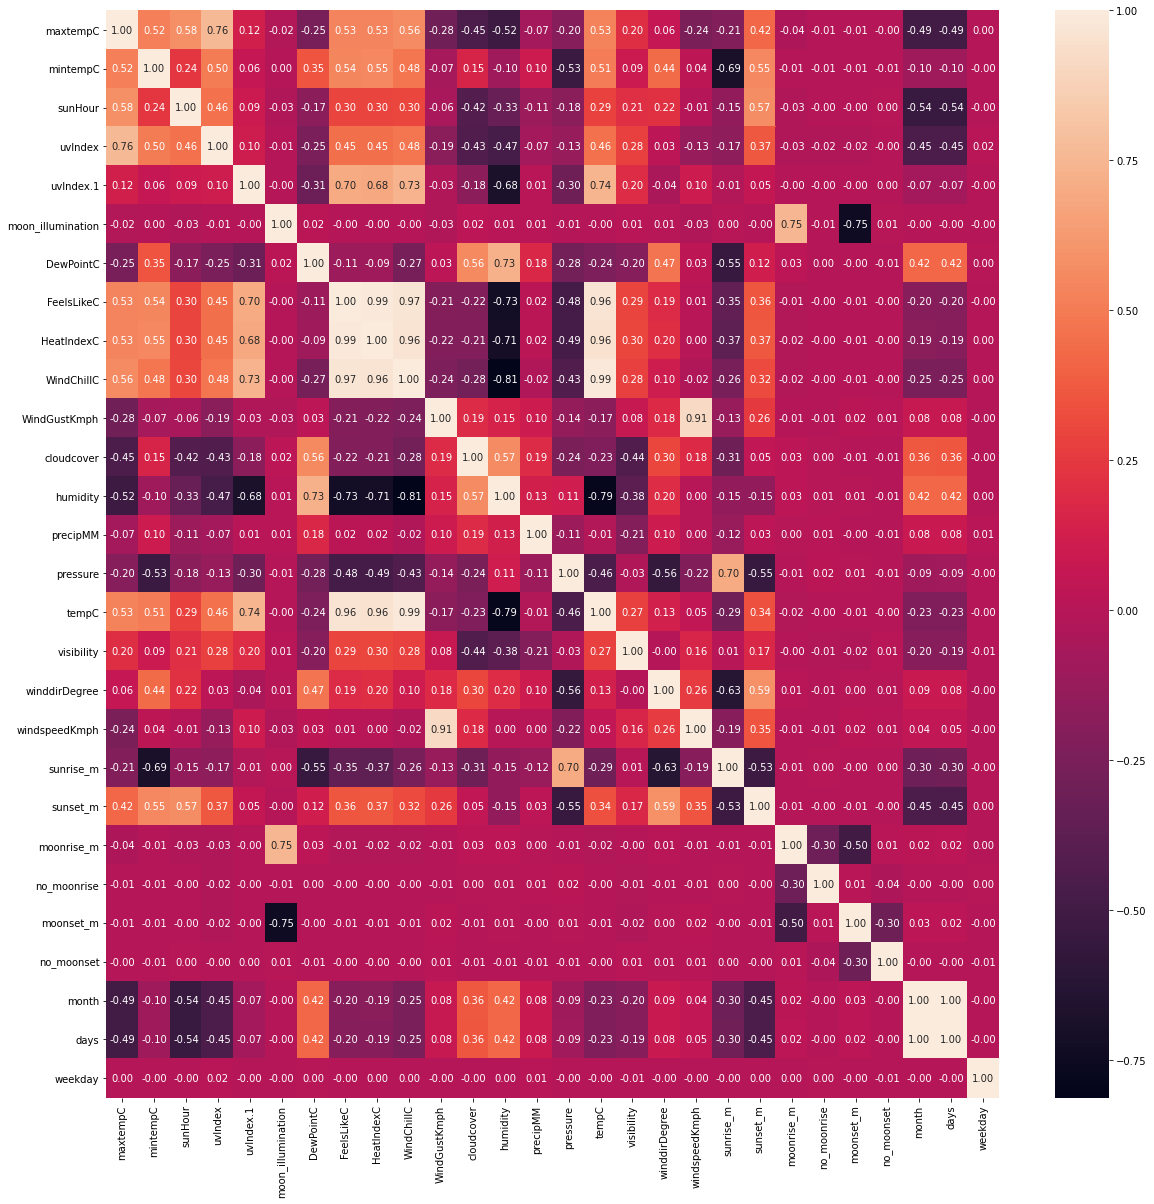

In [13]:
#Compute pairwise correlation of columns
plt.figure( figsize=(20,20))
sn.heatmap(dataset.corr(), annot=True, fmt='.2f')

## Data Exploration

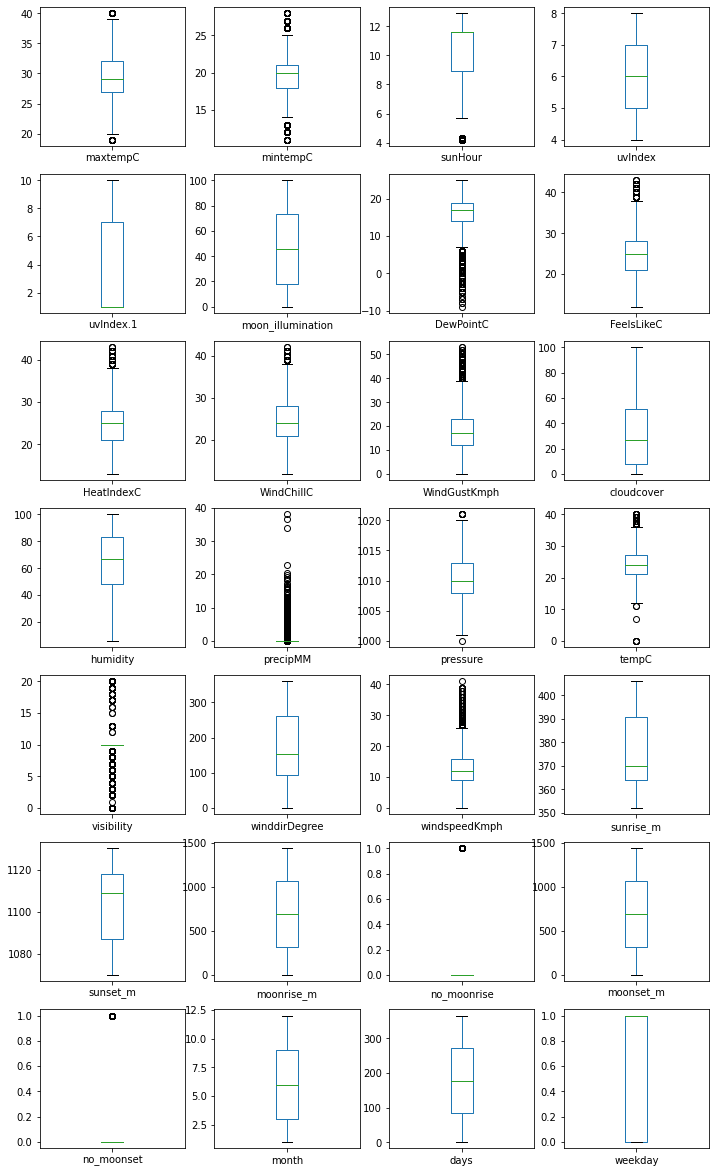

In [14]:
# checking how all the features are varying
dataset.plot(kind='box',subplots=True, layout=(7,4),figsize=(12,21))
plt.show()

<p style="color:green">no_moonrise and no_moonset are categorical data></p>

In [15]:
dataset.shape

(30144, 28)

In [16]:
dataset.columns

Index(['maxtempC', 'mintempC', 'sunHour', 'uvIndex', 'uvIndex.1',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'sunrise_m', 'sunset_m', 'moonrise_m', 'no_moonrise', 'moonset_m',
       'no_moonset', 'month', 'days', 'weekday'],
      dtype='object')

In [17]:
dataset.corr()['windspeedKmph'].sort_values(ascending=False)

windspeedKmph        1.0000
WindGustKmph         0.9117
sunset_m             0.3492
winddirDegree        0.2595
cloudcover           0.1802
visibility           0.1614
uvIndex.1            0.0952
tempC                0.0467
days                 0.0455
month                0.0441
mintempC             0.0360
DewPointC            0.0303
moonset_m            0.0198
no_moonset           0.0150
FeelsLikeC           0.0094
precipMM             0.0047
humidity             0.0031
HeatIndexC           0.0031
weekday             -0.0017
moonrise_m          -0.0085
no_moonrise         -0.0092
sunHour             -0.0107
WindChillC          -0.0200
moon_illumination   -0.0292
uvIndex             -0.1304
sunrise_m           -0.1923
pressure            -0.2213
maxtempC            -0.2397
Name: windspeedKmph, dtype: float64

[]

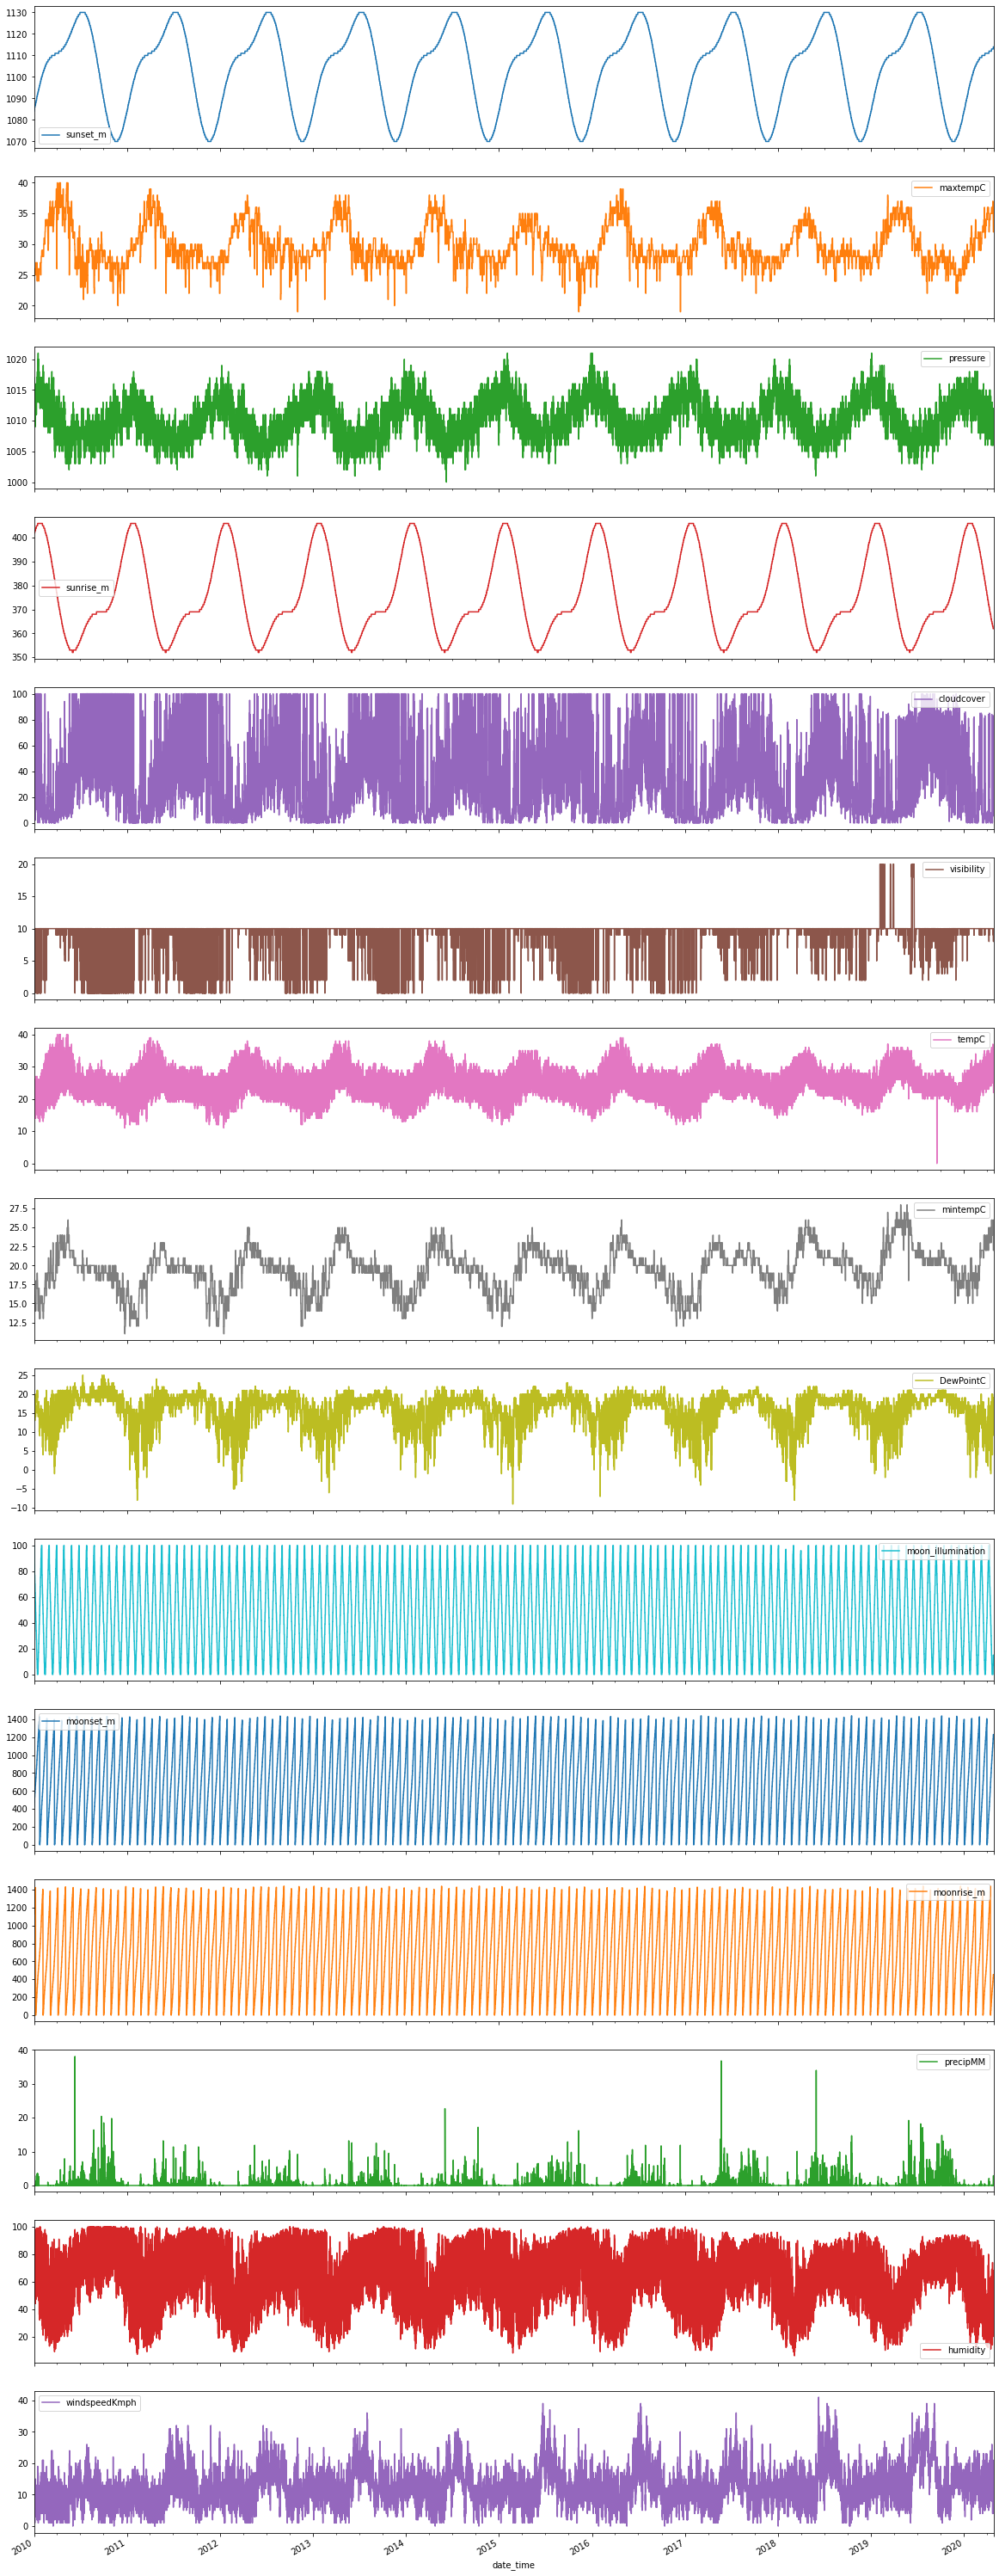

In [18]:
dataset1 = dataset[['sunset_m','maxtempC', 'pressure', 'sunrise_m', 'cloudcover', 'visibility',
       'tempC', 'mintempC','DewPointC', 'moon_illumination', 'moonset_m',
        'moonrise_m','precipMM', 'humidity','windspeedKmph']]
dataset1.plot(subplots=True,figsize=(20,60))
plt.plot()

In [0]:
forecast_data = dataset[['sunrise_m', 'sunset_m', 'maxtempC', 'mintempC', 'pressure',
                         'cloudcover', 'visibility','uvIndex','DewPointC', 'moon_illumination', 'moonset_m', 'moonrise_m',
                         'precipMM', 'humidity', 'tempC', 'windspeedKmph']]

In [20]:
forecast_data.tempC.replace(0, method='ffill', inplace=True)
forecast_data.shape

(30144, 16)

## 3 Hour forecast

In [0]:
def minMaxScaler(data, feature_range=(0,1)):
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler = scaler.fit(data)
    scaled = scaler.transform(data)
    return scaler, scaled

In [0]:
scaler, scaled = minMaxScaler(forecast_data)

In [23]:
type(scaled)

numpy.ndarray

In [0]:
# split a univariate sequence into samples
def splitSequence(seq, n_step):
    X, y = [],[]
    for i in range(len(seq)):
        # find the end of this pattern
        end_ix = i+n_step
        # check if we are beyond the sequence
        if end_ix >= len(seq):
            break
        X.append(seq[i:end_ix])
        y.append(seq[end_ix])
    return np.array(X), np.array(y)

In [25]:
# choose a number of time steps
n_step = 128
X, y = splitSequence(scaled, n_step)
print(X.shape, y.shape)

(30016, 128, 16) (30016, 16)


In [0]:
# We are going to forecast 'humidity', 'tempC', 'windspeedKmph'
y = y[:,-2:]
dense_units = 2

In [0]:
# define model
def vanillaLSTMModel(lstm_units = 50, dense_units = 2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape = X.shape[1:]))
    model.add(Dropout(0.2))
    model.add(Dense(dense_units))
    return model


In [0]:
val_X, val_y = X[-300:], y[-300:]

In [29]:
model = vanillaLSTMModel()
model.compile(optimizer='adam', loss = 'mse')
model.fit(X[:-300], y[:-300], epochs=30, batch_size = 32, validation_data=(val_X, val_y),
         callbacks=[EarlyStopping(monitor='val_loss', patience=5),ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')], verbose=1, shuffle=False)

Train on 29716 samples, validate on 300 samples
Epoch 1/30
29716/29716 [==============================] - 62s 2ms/step - loss: 0.0188 - val_loss: 0.0154
Epoch 2/30
29716/29716 [==============================] - 62s 2ms/step - loss: 0.0082 - val_loss: 0.0055
Epoch 3/30
29716/29716 [==============================] - 65s 2ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 4/30
29716/29716 [==============================] - 64s 2ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 5/30
29716/29716 [==============================] - 66s 2ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/30
29716/29716 [==============================] - 64s 2ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 7/30
29716/29716 [==============================] - 65s 2ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/30
29716/29716 [==============================] - 65s 2ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 9/30
29716/29716 [==============================] - 66s 2ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 1

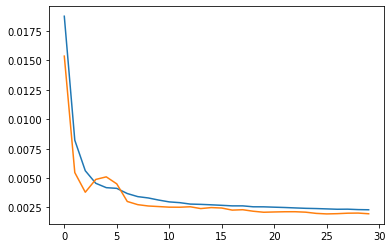

In [30]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [0]:
# from keras.models import load_model
# model = load_model("saved_model")

In [0]:
# demonstrate prediction
pred = model.predict(val_X)
pred_inv_scaled = np.around(pred * scaler.data_range_[-2:] + scaler.data_min_[-2:])
act_inv_scaled = np.around(val_y * scaler.data_range_[-2:] + scaler.data_min_[-2:])

In [32]:
print("MSE for windspeedKmph :",mean_absolute_error(pred_inv_scaled[:,-1], act_inv_scaled[:,-1]))
print("MSE for tempC :",mean_absolute_error(pred_inv_scaled[:,-2], act_inv_scaled[:,-2]))

MSE for windspeedKmph : 1.7366666666666666
MSE for tempC : 0.67


In [33]:
from sklearn.metrics import r2_score
print(r2_score(act_inv_scaled[:,-1],pred_inv_scaled[:,-1]))

0.7619330735907905


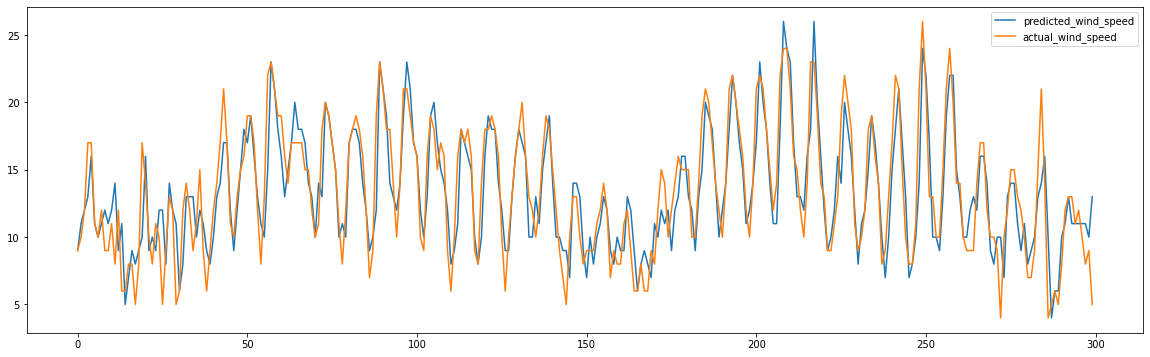

In [34]:
plt.figure(figsize=(20,6))
plt.plot(pred_inv_scaled[:,-1], label= 'predicted_wind_speed')
plt.plot(act_inv_scaled[:,-1], label = 'actual_wind_speed')
plt.legend()

In [0]:
pred_df = pd.DataFrame(pred_inv_scaled, columns=['tempC', 'windspeedKmph'])

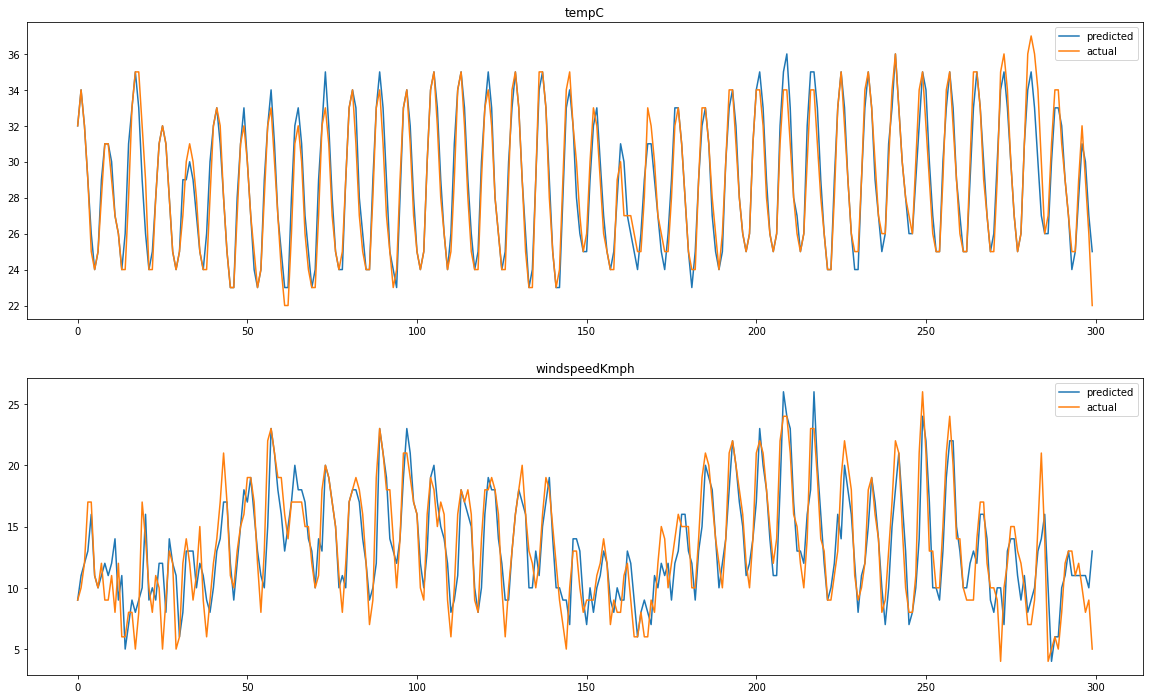

In [36]:
# demonstrate prediction
pred_data = pred_df.values
fig = plt.figure(figsize=(20,12))
ax = fig.subplots(2,1)
for i in range(pred.shape[1]):
    ax[i].set_title(pred_df.columns[i])
    ax[i].plot(pred_data[:,i], label='predicted')
    ax[i].plot(act_inv_scaled[:,i], label = 'actual')
    ax[i].legend()